# Introduction

Ce notebook présente une approche pour déterminer les couleurs d'une image initialement en noir et blanc, en utilisant les bibliothèques numpy et skimage, puis en explorant en complément un algorithme de Machine Learning.

Ce projet s'intègre dans le cadre du cours I3 Python Scientifique de Centrale Méditerannée. Il a été mené par Thomas Roujou et Mathis Rezaï.

Il suit le plan suivant :

I. Une première approche à partir de la fonction rgb2gray

II. Une deuxième approche via une régression linéaire

1. Construction du modèle

2. Résultats en fonction des jeux de données

Conclusion


Bonus : approche via réseau de neurones avec la bibliothèque tensorflow

1. Elaboration de réseau de neurones

2. Entrainement du modèle et Visualisation




# I. Une première approche à partir de la fonction rgb2gray

Pour télécharger le jeu de données, il faut suivre les instructions suivantes:
premièrement, allez à l'adresse ci-dessous et téléchargez les images https://drive.google.com/drive/folders/1n6lY51CVLQ27nJCAHiaJCNn1uWWDMM4X?usp=share_link ensuite importez les sur google collab ou remplacez les chemins d'accès. Créez un dossier noel sur google collab contenant les images "sapin"

Tout d'abord nous devons importer toutes les librairies qui nous seront nécessaires pour cette partie

In [ ]:
import sys
import numpy as np
from skimage import io, color
from skimage.transform import resize
import matplotlib.pyplot as plt

Commençons par télécharger une photographie de mer en couleur. Nous allons la traduire matriciellement avec la fonction io.imread, et la redimensionner pour réduire le volume de données.

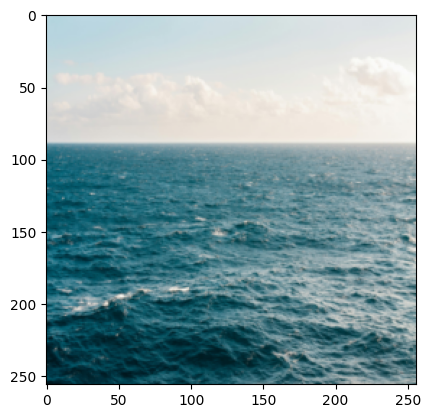

In [ ]:
image_path = '../images/mer.jpg'
image_color = io.imread(image_path)
image_color = resize(image_color, (256, 256), anti_aliasing=True)  # Redimensionne à 256x256
image_color = (image_color * 255).astype(np.uint8)  # Reconvertir en entier
plt.imshow(image_color)

La fonction `rgb2gray` de skimage permet de transformer une image en couleur en une image en noir et blanc. La fonction utilise la formule suivant pour calculer la valeur en niveau de gris.


$$l = 0.2125 \cdot R + 0.7154 \cdot G + 0.0721 \cdot B$$


Avec :
- \(R\) : Intensité du canal rouge.
- \(G\) : Intensité du canal vert.
- \(B\) : Intensité du canal bleu.
- \(l\) : Valeur en niveaux de gris (luminance).

Les coefficients utilisés (\(0.2125\), \(0.7154\), \(0.0721\)) sont basés sur la norme **ITU-R BT.709**, qui reflète la perception humaine des couleurs.


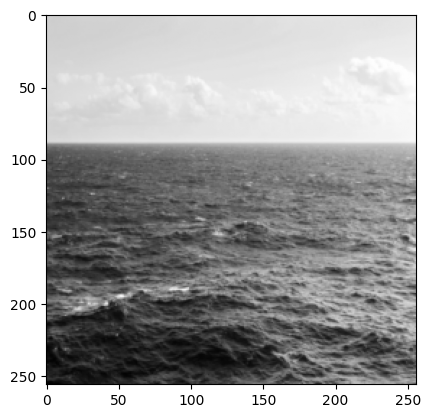

In [ ]:
image_gray = color.rgb2gray(image_color)
plt.imshow(image_gray, cmap = 'gray') # cmap = 'gray' force une échelle de gris pour empêcher la colormap viridis (mise par défaut) de mettre des fausses couleurs.

Une première idée simple nous est alors venue : nous voulions essayer de créer une une fonction inverse, qui permettrait alors de colorer une image en noir et blanc, grâce à la formule de la lumiance utilisée par la foncrion précédente. Voici la fonction `gray2rgb`, fonction "inverse" de `rgb2gray`.

In [ ]:
def gray2rgb(image_gray):
    """
    Convertit une image en niveaux de gris (2D) en une image RGB (3D)
    en utilisant les coefficients de la norme ITU-R BT.709.

    Paramètres:
        image_gray (numpy.ndarray): Image en niveaux de gris (2D).

    Retour:
        numpy.ndarray: Image RGB (3D) où chaque pixel contient [R, G, B].
    """
    # Vérification que l'image est bien en niveaux de gris (2D)
    if len(image_gray.shape) != 2:
        raise ValueError("L'image d'entrée doit être en niveaux de gris (2D).")

    # Coefficients de pondération de la norme ITU-R BT.709
    coeffs = np.array([0.2125, 0.7154, 0.0721])

    # Créer une image RGB en appliquant les coefficients
    image_rgb = np.stack([
        image_gray * coeffs[0],  # rouge
        image_gray * coeffs[1],  # vert
        image_gray * coeffs[2]   # bleu
    ], axis=-1)
    return np.clip(image_rgb, 0, 1)  # Normalisation pour rester entre 0 et 1


Maintenant que la fonction est créee, nous pouvons la tester sur notre photogaphie de mer et comparer les images :

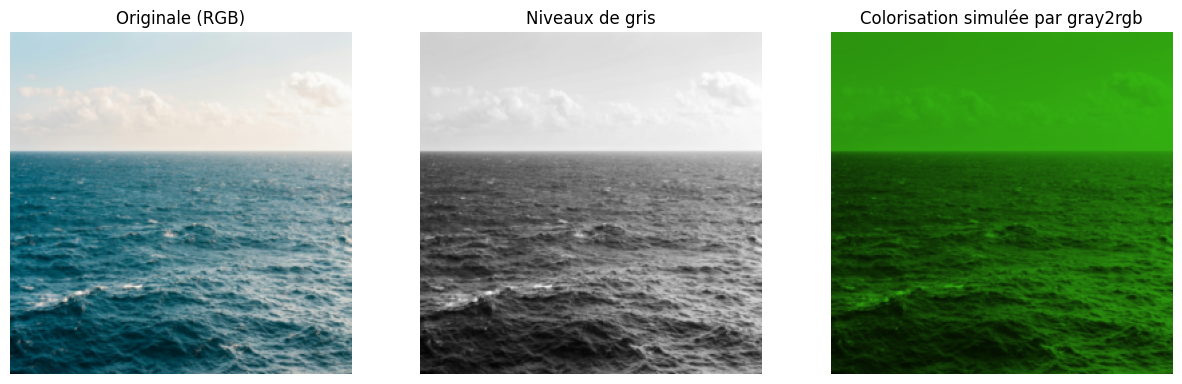

In [ ]:
# Appliquer la fonction gray2rgb
image_rgb_simulated = gray2rgb(image_gray)

# Afficher les résultats
plt.figure(figsize=(15, 5))

# Image originale
plt.subplot(1, 3, 1)
plt.imshow(image_color)
plt.axis('off')
plt.title("Originale (RGB)")

# Image en niveaux de gris
plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.title("Niveaux de gris")

# Image simulée
plt.subplot(1, 3, 3)
plt.imshow(image_rgb_simulated)
plt.axis('off')
plt.title("Colorisation simulée par gray2rgb")

plt.show()


On remarque que pour une image quasiment monochrome comme la mer, la fonction ne renvoie même pas la bonne couleur. Ainsi la fonction `gray2rgb` ne peut pas fonctionner correctement et ce pour plusieurs raisons.

Lors de la conversion d'une image RGB (en couleur) en niveaux de gris, les trois canaux de couleur ($R$, $G$, $B$) sont combinés en un seul canal de luminance ($l$) en utilisant la formule suivante :

$$
l = 0.2125 \cdot R + 0.7154 \cdot G + 0.0721 \cdot B
$$

Cette transformation entraîne une perte d'informations. Plusieurs combinaisons de $R$, $G$, $B$ différentes peuvent produire la même valeur de $l$. Par exemple :
$(R, G, B) = (100, 200, 50)$ et $(R, G, B) = (150, 180, 70)$ peuvent donner exactement le même niveau de gris.

Cette perte rend impossible la reconstruction exacte des couleurs d'origine à partir de l'image en niveaux de gris. En d'autres termes, la fonction `rgb2gray` n'est pas bijective, car elle n'est ni injective (différents $(R, G, B)$ peuvent produire le même $l$) ni surjective (tous les $(R, G, B)$ ne peuvent pas être atteints par une valeur de $l$).

De plus pour que `gray2rgb` fonctionne, l'entrée doit être une image en niveaux de gris, donc une matrice 2D. Si l'entrée est une image en couleur (matrice 3D), la fonction échouera ou produira des résultats incohérents. Même si l'entrée est correcte (une image en niveaux de gris), la fonction attribue des couleurs de manière arbitraire (selon des coefficients prédéfinis) et ne permet pas de retrouver les couleurs d'origine.


Cette première partie nous en apprend plus sur certains outils qu'utilise skimage pour décoloriser une image, mais ne nous permet pas d'ateindre notre objectif : créer un algorithme de colorisation. Nous allons maintenant, dans une seconde partie, utiliser une régression linéaire pour arriver à nos fins.

# II. Une deuxième appproche via une régression linéaire avec la bibliothèque skimage

Pour complexifier et améliorer les résultats, nous allons explorer la régression linéaire, qui est l'un des modèles les plus simples et fondamentaux du machine learning. L'objectif principal sera de comprendre et d'utiliser ce modèle pour prédire les valeurs couleur (R, G, B) d'un pixel en fonction de ses caractéristiques. Voici le développement de cette approche :

In [ ]:
import os
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt

En Machine Learning supervisé, l'objectif est de prédire une variable cible
y
 (comme la couleur d'un pixel, une valeur numérique, etc.) à partir d'un ensemble de descripteurs ou caractéristiques

x (comme les coordonnées, la luminance, ou d'autres propriétés d'un pixel).

La régression linéaire est l'un des modèles les plus simples et fondamentaux pour réaliser cette tâche. Elle suppose que

y peut être exprimée comme une combinaison linéaire des descripteurs
x

Nous cherchons à expliquer la variable cible $y$ par une combinaison linéaire des descripteurs. La fonction de décision est donc de la forme :
\begin{equation}
    f(\mathbf{x}) = \beta_0 + \sum_{j=1}^p \beta_j x_j,
\end{equation}
avec $\mathbf{\beta} \in \mathbb{R}^{p+1}$.


La régression linéaire consiste à trouver les coefficients $\mathbf{\beta}$ qui minimisent la somme des moindres carrés :
\begin{equation}
    \text{argmin}_{\mathbf{\beta} \in \mathbb{R}^{p+1}} \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij}\right)\right)^2.
\end{equation}
Cela peut être récrit sous forme matricielle en ajoutant une colonne de 1 à gauche de la matrice des observations $X \in \mathbb{R}^{n \times p}$ :

$$
    X \leftarrow \begin{pmatrix}
    1 & x_1^1 & \cdots & x_p^1 \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & x_1^n & \cdots & x_p^n
    \end{pmatrix}.
$$
La somme des moindres carrés devient alors :

$$
    \text{RSS} = (\mathbf{y} - X\mathbf{\beta})^T (\mathbf{y} - X\mathbf{\beta}).
$$

Il s’agit d’une forme quadratique convexe en $\beta$, que l’on peut donc minimiser en annulant son gradient

$$
 \nabla_{\mathbf{\beta}} \text{RSS} = -2X^\top \mathbf{y} - X \mathbf{\beta}.
$$

En annulant le gradient $\nabla_{\mathbf{\beta}} \text{RSS}$, on obtient :
\begin{equation}
    X^T X \mathbf{\beta} = X^T \mathbf{y},
\end{equation}
On obtient alors :
$$
\mathbf{\beta}^* = (X^T X)^{-1} X^T \mathbf{y}.
$$

et si $X^T X$ est inversible, la solution est unique et donnée par :
\begin{equation}
    \mathbf{\beta}^* = (X^T X)^{-1} X^T \mathbf{y}.
\end{equation}


In [ ]:
def ajuster_regression_lineaire(X, Y):
    """
    Implémentation de la méthode de régression linéaire.
    Calcule les coefficients : β = (X^T X)^(-1) X^T Y
    """
    X_T = X.T  # Transposée
    beta = np.linalg.inv(X_T @ X) @ X_T @ Y
    return beta


In [ ]:
def predire_regression_lineaire(X, beta):
    """
    Prédictions avec régression linéaire.
    """
    return X @ beta

On convertit chaque image couleur en niveaux de gris.
puis on parcourt chaque pixel de l'image pour collecter les caractéristiques (coordonnées, luminance, et un biais) comme données d'entrée (donnees) et les valeurs couleur (R, G, B) comme cibles (cibles).

In [ ]:
# Répertoire des images d'entraînement
dossier_images_couleur = '/content/noel'  # Images couleur pour l'entraînement

# Préparer les données d'entraînement
donnees = []
cibles = []

for fichier in os.listdir(dossier_images_couleur):
    if fichier.endswith('.jpg') or fichier.endswith('.png'):  # Vérification du format
        # Charger l'image couleur
        chemin_couleur = os.path.join(dossier_images_couleur, fichier)
        image_couleur = io.imread(chemin_couleur)

        # Convertir l'image couleur en niveaux de gris
        image_gris = color.rgb2gray(image_couleur)

        # Collecter les données (X) et les cibles (Y)
        h, w = image_gris.shape
        for x in range(h):
            for y in range(w):
                luminance = image_gris[x, y]
                r, g, b = image_couleur[x, y]
                donnees.append([x, y, luminance, 1])  # Ajouter le biais
                cibles.append([r, g, b])  # Valeurs couleur


In [ ]:
# Convertir les données en tableaux numpy
donnees = np.array(donnees)  # X
cibles = np.array(cibles)  # Y

on définit une taille d'échantillon de 1000 exemples
et on sélectionne aléatoirement 1000 indices parmi les données disponibles, sans remplacement (replace=False).
enfin on crée un sous-ensemble des données d'entrée (echantillon_donnees) et des cibles associées (echantillon_cibles) correspondant aux indices sélectionnés.

In [ ]:
# Réduire la taille des données pour accélérer l'entraînement
taille_echantillon = 10000  # Prendre un sous-ensemble aléatoire
indices = np.random.choice(len(donnees), taille_echantillon, replace=False)
echantillon_donnees = donnees[indices]
echantillon_cibles = cibles[indices]

In [ ]:
# Entraîner le modèle avec les images d'entraînement
beta = ajuster_regression_lineaire(echantillon_donnees, echantillon_cibles)


In [ ]:
# Charger une image de test
chemin_image_test = '/content/cookies.jpg'  # Chemin vers l'image de test
image_test_couleur = io.imread(chemin_image_test)
image_test_gris = color.rgb2gray(image_test_couleur)

# Préparer les données de test
h, w = image_test_gris.shape
donnees_test = []

In [ ]:
for x in range(h):
    for y in range(w):
        luminance = image_test_gris[x, y]
        donnees_test.append([x, y, luminance, 1])  # Ajouter le biais

donnees_test = np.array(donnees_test)
couleurs_predites = predire_regression_lineaire(donnees_test, beta)

# Reconstruction de l'image prédite
image_predite = np.clip(couleurs_predites.reshape(h, w, 3), 0, 255).astype(np.uint8)



In [ ]:
# Calcul des métriques pour évaluer la qualité de la reconstruction
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.color import rgb2lab

mse = mean_squared_error(image_test_couleur, image_predite)  # Mesure l'erreur quadratique moyenne
psnr = peak_signal_noise_ratio(image_test_couleur, image_predite, data_range=255)
# Un PSNR élevé indique une meilleure qualité

# Conversion en espace Lab pour calculer le deltaE
lab_original = rgb2lab(image_test_couleur)
lab_predite = rgb2lab(image_predite)
delta_e = np.mean(np.sqrt(np.sum((lab_original - lab_predite)**2, axis=-1)))  # Mesure de l'erreur perceptuelle

print(f"MSE : {mse:.4f}")
print(f"PSNR : {psnr:.4f} dB")
print(f"Delta E : {delta_e:.4f}")


MSE : 339.3643
PSNR : 22.8241 dB
Delta E : 15.8644


Le code calcule trois métriques pour évaluer la qualité de la colorisation :

MSE (Erreur quadratique moyenne) : Mesure la différence moyenne entre les couleurs réelles et prédites. Plus cette valeur est faible, mieux c'est.

PSNR (Peak Signal-to-Noise Ratio) : Indique la qualité de la reconstruction ; plus cette valeur est élevée, mieux c'est.

Delta E : Évalue l'erreur dans l'espace de couleur perceptuel (Lab). Une valeur faible indique une meilleure reconstruction visuelle.

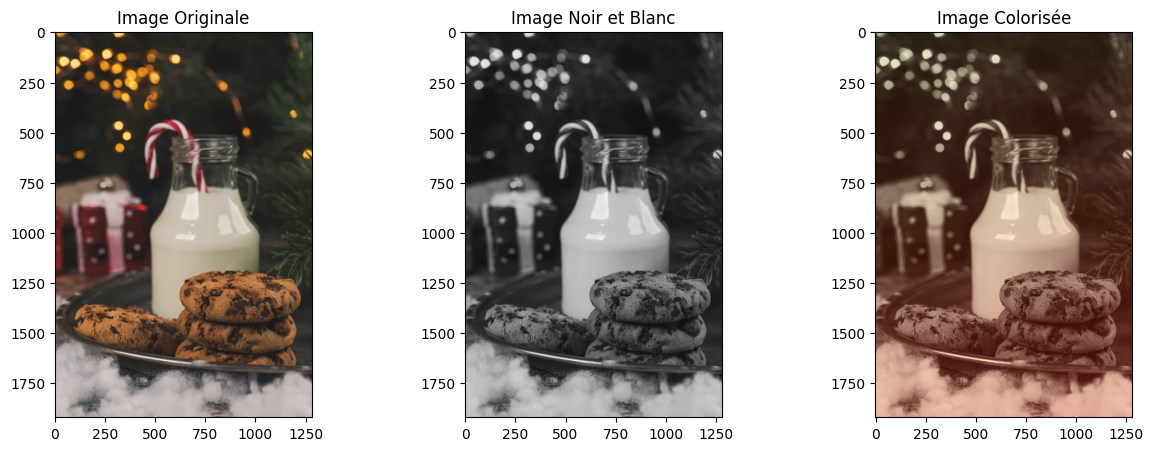

In [ ]:
 # Sauvegarder et afficher les résultats
io.imsave('image_colorisee_simple.jpg', image_predite)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_test_couleur)
axes[0].set_title('Image Originale')

axes[1].imshow(image_test_gris, cmap='gray')
axes[1].set_title('Image Noir et Blanc')

axes[2].imshow(image_predite)
axes[2].set_title('Image Colorisée')

plt.show()



# Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;L'approche présentée ci-dessus se distingue comme la plus efficace parmi les méthodes testées dans le cadre du projet, bien qu'elle reste perfectible en comparaison avec des solutions plus avancées nécessitant l'utilisation de bibliothèques spécialisées en machine learning telles que scikit-learn ou tensorflow. Ces outils permettent en effet de considérablement améliorer les performances des modèles en offrant des fonctionnalités plus robustes et adaptées, par exemple via l'utilisation de modèles optimisés disponibles dans des bibliothèques comme scikit-image. Cependant, en se limitant au modèle de régression linéaire, on observe une grande variabilité des résultats en fonction de plusieurs facteurs, parmi lesquels la qualité et la nature des images de test utilisées, le nombre d'images prises en compte, et les perturbations pouvant découler de certains scénarios d'expérimentation. Cette variabilité est également accentuée par le fonctionnement intrinsèque de l'algorithme, qui repose sur la minimisation d'une somme de carrés. Cette caractéristique conduit à une pénalisation disproportionnée des erreurs de grande amplitude, ce qui peut expliquer l'effet de "filtre" observé sur les images produites. En effet, il s'avère généralement plus simple pour l'algorithme de tendre vers une moyenne, réduisant ainsi les écarts importants, plutôt que de représenter fidèlement des variations plus marquées. Par conséquent, bien que cette méthode soit adaptée à une certaine simplicité d'implémentation et à des cas d'utilisation spécifiques, elle montre ses limites dans des contextes où une précision accrue ou une meilleure gestion des erreurs est requise mais reste excellente sur des images simple de mer par exemple, nous avons volontairement choisit des images complexe pour réfléter la variable entre le résultat attendu et le résultat obtenu. D'autres méthodes simples comme l'application de filtre de couleur on également été mais sont inutiles pour des images complexes.

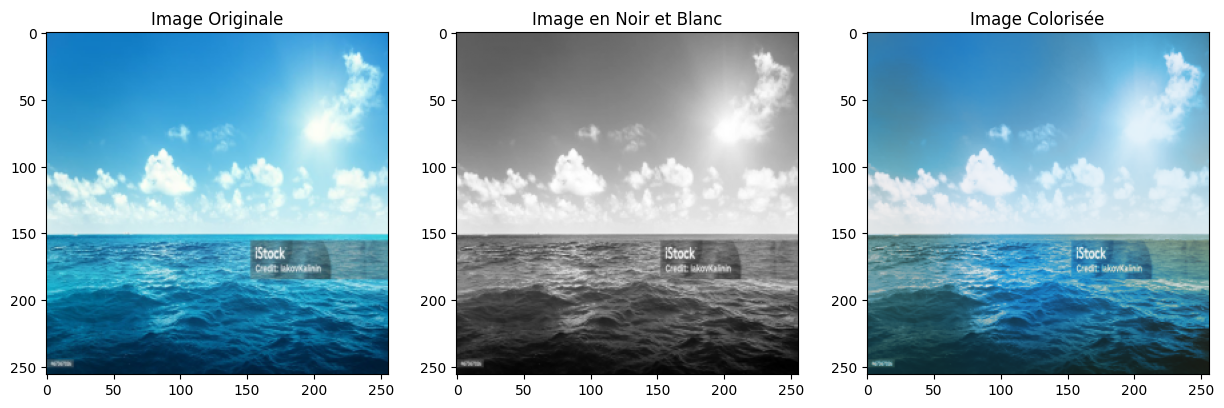

(ci-dessus l'image obtenue grace à la régréssion linéaire pour une image de mer simple avec un jeu de données de bords de mer)

# Bonus : approche via réseau de neurones avec la bibliothèque tensorflow

Lors de nos recherches sur ce sujet, nous avons trouvé
 des algorithmes existant de réseau de neurones pour coloriser des images. Par exemple, le projet open source Deoldify, premier sur la colorisation d'image, utilise ce type d'apprentissage profond.

Nous nous sommes donc intéressés à cette méthode et avons crée l'algorithme suivant de colorisation, ce qui nous a cependant demandé une certaine documentation sur les réseaux de neurones que nous n'avons pas encore vu en cours.

Tout d'abord nous devons importer la librairie tensorflow et glob

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import glob

Téléchargeons ensuite le dataset contenant les photos en couleur dans le thème "Noël" en utilisant la fonction glob

In [ ]:
# Récupérer les chemins des images dans le dossier spécifié
chemins_images = glob.glob('/content/noel/*')



On va ensuite créer deux listes : une liste `donnees` contenant les positions de chaque pixel ainsi que leur luminance associée, et une liste `cibles` comprenant les intensités de rouge, vert et bleu, pour chacun de ces pixels. Les possitions ainsi que les intensités sont normalisées

In [ ]:
# Initialiser les listes pour les données et les cibles
donnees = []
cibles = []
for chemin_image in chemins_images:
    # Charger l'image en couleur
    image_couleur = io.imread(chemin_image)
    # Redimensionner l'image à 256x256
    image_couleur = resize(image_couleur, (256, 256), anti_aliasing=True)
    # Convertir les valeurs de l'image en entiers
    image_couleur = (image_couleur * 255).astype(np.uint8)
    # Convertir l'image couleur en niveaux de gris
    image_gris = color.rgb2gray(image_couleur)

    hauteur, largeur, _ = image_couleur.shape
    for x in range(hauteur):
        for y in range(largeur):
            luminance = image_gris[x, y]
            r, g, b = image_couleur[x, y]
            # Normaliser les coordonnées et la luminance
            donnees.append([x / hauteur, y / largeur, luminance])
            # Normaliser les valeurs RGB
            cibles.append([r / 255, g / 255, b / 255])

On convertit ensuite les listes en arraylists (nécessaire pour tensorflow) :

In [ ]:
# Convertir les données en tableaux numpy
donnees = np.array(donnees)
cibles = np.array(cibles)

Nous allons être amenés à entrainer notre modèle. Pour cela on va sélectionner un sous-ensemble aléatoire de 300 000 pixels pour réduire la charge d'entrainement

In [ ]:
# Sélectionner un échantillon aléatoire de 300 000 pixels pour l'entraînement
taille_echantillon = 300000
indices = np.random.choice(len(donnees), taille_echantillon, replace=False) # choix des 300 000 indices
echantillon_donnees = donnees[indices]
echantillon_cibles = cibles[indices]

Nous allons ensuite diviser le jeu de données en deux :

- 80% des données vont servir à l'entraînement du modèle

- les 20% restants pour la validation


In [ ]:
# Diviser les données : 80 % pour l'entraînement, 20 % pour la validation
index_separation = int(len(echantillon_donnees) * 0.8)
X_train, X_val = echantillon_donnees[:index_separation], echantillon_donnees[index_separation:]
y_train, y_val = echantillon_cibles[:index_separation], echantillon_cibles[index_separation:]

Maintenant nous allons utiliser la bibliothèque tensorflow pour créer un réseau de neurones. L'objectif de ce réseau est d'apprendre à prédire la couleur d'un pixel en fonction du pixel en noir et blanc qu'on lui donne en entrée.

Nous allons définir le réseau par des couches de neurones, linéairement. Tout d'abord nous définissons la forme des données d'entrée du réseau avec la fonction `Input`. Ici chaque entrée est un pixel avec 3 caractéristiques :
- Ses coordonnées (x,y) normalisées
- sa luminance

On définit ensuite 3 couches, avec la fonction `Dense`. Chaque couche reçoit l'entrée de la couche précédente. Chaque neurone est connecté à tous ceux de la couche précédente. Chaque neurone a des poids et un biais associés. Ils sont initialisés automatiquement, et sont voués à être ajustés au cours de l'entraînement par un processus d'optimisation.

1. **Somme pondérée :**
   $z = \sum_{i=1}^n w_i \cdot x_i + b$
   où :
   - $z$ : sortie non activée (somme pondérée),
   - $n$ : nombre d'entrées,
   - $w_i$ : poids associé à la $i$-ème entrée,
   - $x_i$ : $i$-ème entrée,
   - $b$ : biais (terme constant ajouté à la somme).

2. **Sortie activée :**
   $a = f(z)$
   où :
   - $a$ : sortie activée du neurone,
   - $f(z)$ : fonction d'activation (par exemple, ReLU ou Sigmoid)

   avec :
   $\ {ReLU}(z) = \max(0,z)$

   $\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}$

Ces fonctions sont là pour introduire de la non-linéarité et permettre au réseau d'apprendre des relations complexes entre les données d'entrée et la sortie.


En sortie du réseau nous avons un vecteur de dimension 3, correspondant au valeurs $(r,g,b)$ associée au pixel d'entrée.

In [ ]:
# Définir le réseau de neurones. 4 Couches de 3, puis 64, encore 64, et enfin 3 neurones.
modele = Sequential([
    Input(shape=(3,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='sigmoid')
])

Avant d'entraîner le modèle, nous allons spécifier :
- comment il doit évaluer les erreurs (avec la fonction de perte, ici nous prendrons la Mean Squared Error)
- comment il doit ajuste ses poids (avec l'optimiseur, nous prendrons Adam)
-quels critères utiliser pour ses performances (aves les métriques, nous prendrons la Mean Absolute Error)

Nous pouvons désormais entraîner le modèle avec
nos données d'entraînement.

In [ ]:
# Compiler le modèle
modele.compile(optimizer='adam', loss='mse', metrics=['mae'])
# Entraîner le modèle
modele.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0220 - mae: 0.1022 - val_loss: 0.0065 - val_mae: 0.0516
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0065 - mae: 0.0519 - val_loss: 0.0063 - val_mae: 0.0511
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0064 - mae: 0.0513 - val_loss: 0.0062 - val_mae: 0.0497
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062 - mae: 0.0500 - val_loss: 0.0061 - val_mae: 0.0495
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0061 - mae: 0.0493 - val_loss: 0.0060 - val_mae: 0.0483
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0060 - mae: 0.0488 - val_loss: 0.0060 - val_mae: 0.0482
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0060 - mae: 0.0485 - val_loss: 0.0059 - val_mae: 0.0483
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0059 - mae: 0.0483 - val_loss: 0.0059 - val_mae: 0.0480
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

Testons maintenant notre modèle avec une image neutre, que le modèle ne connait pas

In [ ]:

# Charger une nouvelle image pour tester le modèle
chemin_image_test = '/content/sapin6.jpg'
image_couleur_test = io.imread(chemin_image_test)
image_couleur_test = resize(image_couleur_test, (256, 256), anti_aliasing=True)
image_couleur_test = (image_couleur_test * 255).astype(np.uint8)
image_gris_test = color.rgb2gray(image_couleur_test)

hauteur_test, largeur_test, _ = image_couleur_test.shape

donnees_test = []
for x in range(hauteur_test):
    for y in range(largeur_test):
        luminance = image_gris_test[x, y]
        donnees_test.append([x / hauteur_test, y / largeur_test, luminance])

donnees_test = np.array(donnees_test)

# Prédire les couleurs à partir des données de test
couleurs_predites = modele.predict(donnees_test, batch_size=512)

# Reconstruire l'image colorisée
image_predite = ((couleurs_predites.reshape(hauteur_test, largeur_test, 3)) * 255).astype(np.uint8)


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Nous réutilisons les métrique utilisées dans la partie 2, et nous affichons enfin les résultats


MSE : 267.8110
PSNR : 23.8525 dB
Delta E : 11.3517


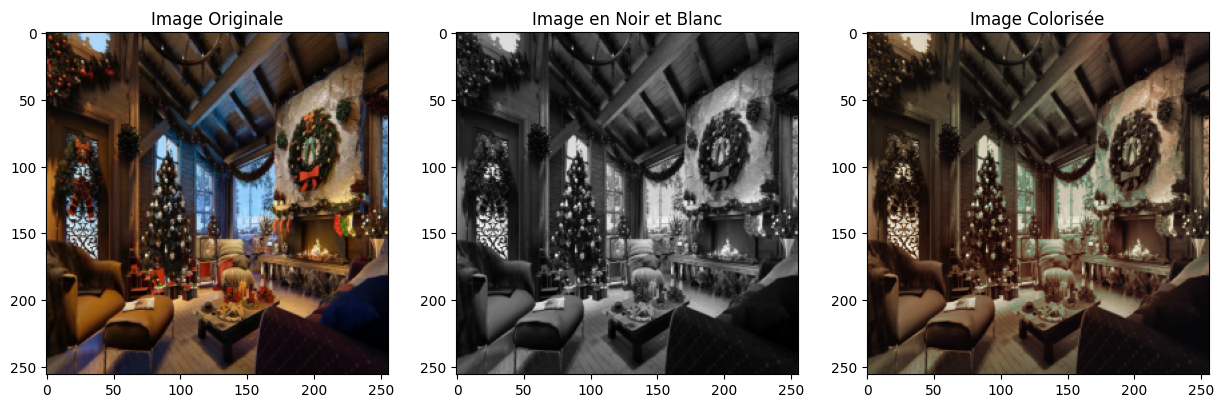

In [ ]:
# Calculer les métriques pour évaluer la qualité de la reconstruction
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from skimage.color import rgb2lab

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(image_couleur_test, image_predite)
# Calcul du rapport signal-bruit de crête (PSNR)
psnr = peak_signal_noise_ratio(image_couleur_test, image_predite, data_range=255)

# Conversion en espace Lab pour calculer Delta E
lab_original = rgb2lab(image_couleur_test)
lab_predite = rgb2lab(image_predite)
delta_e = np.mean(np.sqrt(np.sum((lab_original - lab_predite)**2, axis=-1)))

# Afficher les résultats
print(f"MSE : {mse:.4f}")
print(f"PSNR : {psnr:.4f} dB")
print(f"Delta E : {delta_e:.4f}")

# Sauvegarder l'image colorisée
io.imsave('image_colorisee_nn_redimensionnee.jpg', image_predite)

# Afficher les images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_couleur_test)
axes[0].set_title('Image Originale')

axes[1].imshow(image_gris_test, cmap='gray')
axes[1].set_title('Image en Noir et Blanc')

axes[2].imshow(image_predite)
axes[2].set_title('Image Colorisée')

plt.show()

